###  Сулейманов Ильяс

Построить графики распределения в спам и не спам множествах следующих признаков:

1)	Количество слов на странице

2)	Средняя длинна слова

3)	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)

4)	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)

5)	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

In [327]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import pandas as pd
import numpy as np

from collections import namedtuple
from pymorphy2 import MorphAnalyzer

from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as PrecRecFbScore

%matplotlib inline
import matplotlib.pyplot as plt

morph = MorphAnalyzer()

14:47:46 INFO:Loading dictionaries from /home/danroor/anaconda3/lib/python3.7/site-packages/pymorphy2_dicts_ru/data
14:47:46 INFO:format: 2.4, revision: 404381, updated: 2017-08-28T16:38:19.536338


In [2]:
TRACE_NUM = 1000
import logging
from importlib import reload
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [141]:
from html.parser import HTMLParser
import re

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        
        self._title = ""
        self._text = []
        self._anchors = []
        
        self._script_cnt = self._link_cnt = self._img_cnt = 0
        self._in_title = self._in_anchor = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            
            if self._in_title:
                self._title = text  
            elif self._in_anchor:
                self._anchors.append(text + ' ')
            else:
                self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'title':
            self._in_title = True
            return
        elif tag == 'a':
            self._in_anchor = True
            return
        elif tag == 'script':
            self._script_cnt += 1
        elif tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
            
    def handle_endtag(self, tag):
        if tag == 'title':
            self._in_title = False
        if tag == 'a':
            self._in_anchor = False

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')
        elif tag == 'img':
            self._img_cnt += 1
        elif tag == 'link':
            self._link_cnt += 1

    def text(self):
        return ''.join(self._text).strip()
    
    def title(self):
        return self._title
    
    def anchors_text(self):
        return ''.join(self._anchors).strip()
    
    def images(self):
        return self._img_cnt
    
    def links(self):
        return self._link_cnt
    
    def scripts(self):
        return self._script_cnt

#### Методы для токенизации текста

In [142]:
@convert2lower
def easy_tokenizer(text):
    word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = ''
    if word: yield word

#### Основная функция, которая вызывается для извлечения слов и признаков из html

In [143]:
def html_features(raw_html, Parser = TextHTMLParser, tokenizer=easy_tokenizer):
    
    parser = Parser()
    parser.feed(raw_html)
    
    title  = list(tokenizer(parser.title()))
    text   = list(tokenizer(parser.text()))
    anchors = list(tokenizer(parser.anchors_text()))
    
    images  = parser.images()
    links   = parser.links()
    scripts = parser.scripts()
    
    return { 'title'   : title,
             'text'    : text,
             'anchors' : anchors,
             'images'  : images,
             'links'   : links,
             'scripts' : scripts }

#### Рассчет финальных метрик

In [189]:
def calculate_metrics(docs, classifier):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    """
    
    predictions = classifier.predict_all(docs)
    
    true = [i[1] for i in predictions]
    predictions = [i[3] for i in predictions]
    
    precision, recall, F1, _ = PrecRecFbScore(true, predictions)
    
    not_class_prec,   class_prec   = precision[0], precision[1]
    not_class_recall, class_recall = recall[0],    recall[1]
    not_class_F1,     class_F1     = F1[0],        F1[1]
    
    return { 'class_prec' : class_prec,
             'class_recall' : class_recall,
             'class_F1' : class_F1,
             'not_class_prec' : not_class_prec,
             'not_class_recall' : not_class_recall,
             'not_class_F1' : not_class_F1 }

In [311]:
def calc_features(url, html_data):
    
    compression_level = len(html_data) / len(zlib.compress(html_data.encode('utf-8')))
    
    features = html_features(html_data)
    
    #lists of words
    title  = features['title']
    text   = features['text']
    anchor = features['anchors']
    
    #amount of images, links and scripts
    images  = features['images']
    links   = features['links']
    scripts = features['scripts']
    
    title_words_num  = len(title)
    anchor_words_num = len(anchor)
    
    words_num = title_words_num + anchor_words_num + len(text)
    
    unique_title = set(title)
    unique_text = set(text)
    unique_anchor = set(anchor)
    
    def normalize(unique):
        to_delete = set()
        to_add = set()
        
        for i in unique:   
            to_add1 = set()
            word = i.lower()
            
            for parse in morph.parse(word):
                
                norm = parse.normal_form
                to_add1.add(norm)
                
                if word == norm:
                    break
                    
            # 1. Cлово в своей нормальной форме, оставляем только ее
            #   (другие нормальные формы не берем)
            # 2. Слово из служебной части речи.
            #    Уже удалили, переходим к след. слову
            if word == norm:
                continue
                    
            #добавляем все возможные нормальные формы слова
            #для слова в ненормальной форме
            to_add |= to_add1
                
            #удаляем ненормальную форму
            to_delete.add(word)
            
        unique -= to_delete
        unique |= to_add
            
    normalize(unique_title)
    normalize(unique_text)
    normalize(unique_anchor)
        
    unique_words_num = len(unique_title) + len(unique_text) + len(unique_anchor)
    
    title_lengths   = np.array([], dtype = int)
    text_lengths    = np.array([], dtype = int)
    anchor_lengths  = np.array([], dtype = int)
    
    for word in title:
        np.append(title_lengths, len(word))
        
    for word in text:
        np.append(text_lengths, len(word))
        
    for word in anchor:
        np.append(anchor_lengths, len(word))
        
    if text_lengths.size > 0:
        max_len_text = max(text_lengths)
    else:
        max_len_text = 0
    
    if title_lengths.size > 0:
        max_len_title  = max(title_lengths)
    else:
        max_len_title = 0
    
    if anchor_lengths.size > 0:
        max_len_anchor = max(anchor_lengths)
    else:
        max_len_anchor = 0
    
    avg_word_len = ( title_lengths.sum() + text_lengths.sum() + anchor_lengths.sum() ) / words_num
    
    url_len = len(url)        
    url_dots = url.count('.') 
    url_slashes = url.count('/') 
    
    return [words_num,         #количество слов в документе
            unique_words_num,  #количество уникальных слов в документе
            avg_word_len,      #средняя длина одного слова
            
            title_words_num,   #количество слов в заголовке
            anchor_words_num,  #количество слов в якорях-ссылках 
            
            compression_level, #степень сжатия html-кода
            
            url_len,           #длина URL адреса
            url_dots,          #количество точек в URL
            url_slashes,       #количество слэшей в URL
            
            scripts            #JS-скриптов
           ]

In [149]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            
            try:
                html_data = base64.b64decode(pageInb64).decode("utf-8") 
            except UnicodeDecodeError:
                continue
                
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, features)

In [329]:
%%time

train_docs = list(load_csv('kaggle_train_data_tab.csv', calc_features))

14:54:14 INFO:Complete items 00000
14:58:14 INFO:Complete items 01000
15:01:27 INFO:Complete items 02000
15:04:37 INFO:Complete items 03000
15:08:31 INFO:Complete items 04000
15:12:01 INFO:Complete items 05000
15:14:47 INFO:Complete items 06000
15:18:16 INFO:Complete items 07000
15:18:24 INFO:Complete items 07043


CPU times: user 24min 3s, sys: 1.37 s, total: 24min 4s
Wall time: 24min 9s


/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


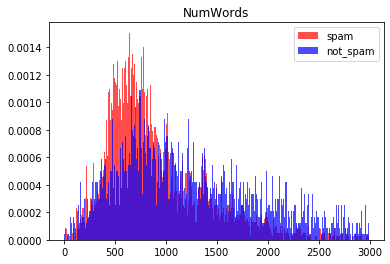

In [140]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


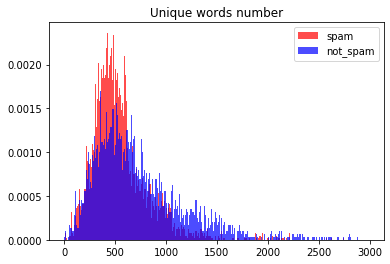

In [346]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Unique words number')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


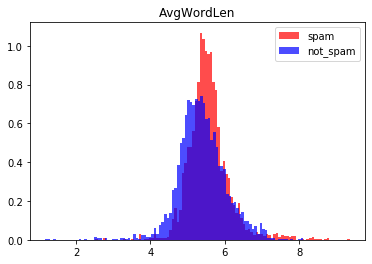

In [141]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


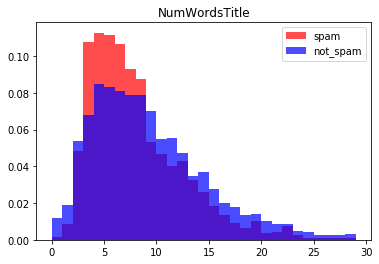

In [142]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


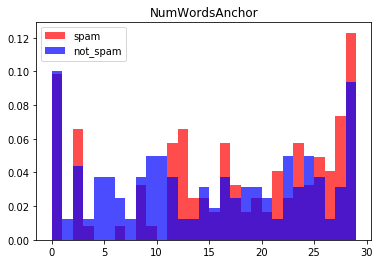

In [143]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


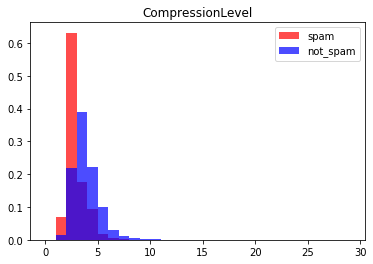

In [144]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('CompressionLevel')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


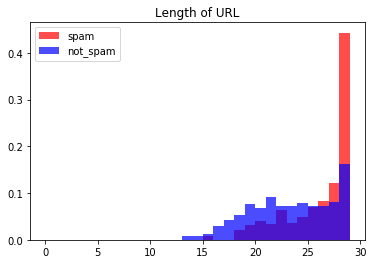

In [67]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Length of URL')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


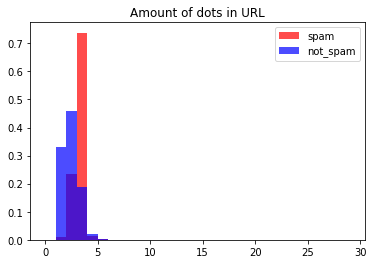

In [68]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Amount of dots in URL')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


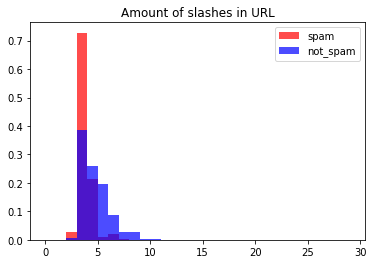

In [347]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Amount of slashes in URL')
plt.legend()
plt.show()

/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/home/danroor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


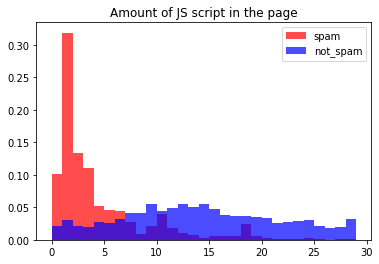

In [348]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Amount of JS script in the page')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [333]:
class Classifier:
        
    def __init__(self, n_estimators, learning_rate, max_depth):
        
        self.classifier = XGBClassifier(n_estimators  = n_estimators,
                                        learning_rate = learning_rate,
                                        max_depth     = max_depth)                    
    
    def predict_all(self, docs):
        
        ids = []
        urls = []
        marks = []
        predictions = []
        features = []
        
        for doc_num, doc in enumerate(docs):                            
            features.append(doc.features)
            ids.append(doc.doc_id)
            urls.append(doc.url)
            marks.append(doc.is_spam)
            trace(doc_num)
        
        predictions = self.classifier.predict(np.array(features))
        predictions = list(map(int, predictions))
        
        return list(zip(ids, marks, urls, predictions))
    
    def train(self, docs):        
        
        features = []
        marks = []
        
        for doc_num, doc in enumerate(docs):                            
            
            features.append(doc.features)
            marks.append(doc.is_spam)
            
            trace(doc_num)
            
        self.classifier.fit(np.array(features), np.array(marks))
            
        trace(doc_num, 1)

In [335]:
best_score = 0

for n_estimators in (500, 750, 1000):
    for learning_rate in (0.05, 0.1, 0.3):
        for max_depth in (3,6):
            
            classifier = Classifier(n_estimators = n_estimators,
                                    learning_rate = learning_rate,
                                    max_depth = max_depth)
            
            classifier.train(train_docs)
            print("{} Estimators, rate {}, depth {}".format(n_estimators, learning_rate, max_depth))
            metrics = calculate_metrics(train_docs, classifier)
            print(metrics)
            
            if (metrics['class_F1'] + metrics['not_class_F1']) / 2 > best_score:
                best_score = (metrics['class_F1'] + metrics['not_class_F1']) / 2
                best_model = classifier
            
            print('#############################')
            
print(best_model)

15:21:59 INFO:Complete items 00000
15:21:59 INFO:Complete items 01000
15:21:59 INFO:Complete items 02000
15:21:59 INFO:Complete items 03000
15:21:59 INFO:Complete items 04000
15:21:59 INFO:Complete items 05000
15:21:59 INFO:Complete items 06000
15:21:59 INFO:Complete items 07000
15:22:00 INFO:Complete items 07042
15:22:00 INFO:Complete items 00000
15:22:00 INFO:Complete items 01000
15:22:00 INFO:Complete items 02000
15:22:01 INFO:Complete items 03000
15:22:01 INFO:Complete items 04000
15:22:01 INFO:Complete items 05000
15:22:01 INFO:Complete items 06000
15:22:01 INFO:Complete items 07000


500 Estimators, rate 0.05, depth 3


15:22:01 INFO:Complete items 00000
15:22:01 INFO:Complete items 01000
15:22:01 INFO:Complete items 02000
15:22:01 INFO:Complete items 03000
15:22:01 INFO:Complete items 04000
15:22:01 INFO:Complete items 05000
15:22:01 INFO:Complete items 06000
15:22:01 INFO:Complete items 07000


{'class_prec': 0.9558858786861664, 'class_recall': 0.970309077634461, 'class_F1': 0.9630434782608696, 'not_class_prec': 0.9575208913649025, 'not_class_recall': 0.9372869802317655, 'not_class_F1': 0.9472959007922839}
#############################


15:22:04 INFO:Complete items 07042
15:22:04 INFO:Complete items 00000
15:22:04 INFO:Complete items 01000
15:22:04 INFO:Complete items 02000
15:22:04 INFO:Complete items 03000
15:22:04 INFO:Complete items 04000
15:22:04 INFO:Complete items 05000
15:22:04 INFO:Complete items 06000
15:22:04 INFO:Complete items 07000


500 Estimators, rate 0.05, depth 6


15:22:04 INFO:Complete items 00000
15:22:04 INFO:Complete items 01000
15:22:04 INFO:Complete items 02000
15:22:04 INFO:Complete items 03000
15:22:04 INFO:Complete items 04000
15:22:04 INFO:Complete items 05000
15:22:04 INFO:Complete items 06000
15:22:04 INFO:Complete items 07000


{'class_prec': 0.9961061085422244, 'class_recall': 0.9961061085422244, 'class_F1': 0.9961061085422244, 'not_class_prec': 0.994546693933197, 'not_class_recall': 0.994546693933197, 'not_class_F1': 0.994546693933197}
#############################


15:22:06 INFO:Complete items 07042
15:22:06 INFO:Complete items 00000
15:22:06 INFO:Complete items 01000
15:22:06 INFO:Complete items 02000
15:22:06 INFO:Complete items 03000
15:22:06 INFO:Complete items 04000
15:22:06 INFO:Complete items 05000
15:22:06 INFO:Complete items 06000
15:22:06 INFO:Complete items 07000
15:22:06 INFO:Complete items 00000
15:22:06 INFO:Complete items 01000
15:22:06 INFO:Complete items 02000
15:22:06 INFO:Complete items 03000
15:22:06 INFO:Complete items 04000
15:22:06 INFO:Complete items 05000
15:22:06 INFO:Complete items 06000
15:22:06 INFO:Complete items 07000


500 Estimators, rate 0.1, depth 3
{'class_prec': 0.9750967117988395, 'class_recall': 0.9815040155755659, 'class_F1': 0.9782898726500909, 'not_class_prec': 0.9738562091503268, 'not_class_recall': 0.9648943421949557, 'not_class_F1': 0.9693545625749016}
#############################


15:22:10 INFO:Complete items 07042
15:22:10 INFO:Complete items 00000
15:22:10 INFO:Complete items 01000
15:22:10 INFO:Complete items 02000
15:22:10 INFO:Complete items 03000
15:22:10 INFO:Complete items 04000
15:22:10 INFO:Complete items 05000
15:22:10 INFO:Complete items 06000
15:22:10 INFO:Complete items 07000


500 Estimators, rate 0.1, depth 6


15:22:10 INFO:Complete items 00000
15:22:10 INFO:Complete items 01000
15:22:10 INFO:Complete items 02000
15:22:10 INFO:Complete items 03000
15:22:10 INFO:Complete items 04000
15:22:10 INFO:Complete items 05000
15:22:10 INFO:Complete items 06000
15:22:10 INFO:Complete items 07000


{'class_prec': 0.9997566909975669, 'class_recall': 1.0, 'class_F1': 0.9998783306971651, 'not_class_prec': 1.0, 'not_class_recall': 0.9996591683708248, 'not_class_F1': 0.9998295551389126}
#############################


15:22:12 INFO:Complete items 07042
15:22:12 INFO:Complete items 00000
15:22:12 INFO:Complete items 01000
15:22:12 INFO:Complete items 02000
15:22:12 INFO:Complete items 03000
15:22:12 INFO:Complete items 04000
15:22:12 INFO:Complete items 05000
15:22:12 INFO:Complete items 06000
15:22:12 INFO:Complete items 07000
15:22:12 INFO:Complete items 00000
15:22:12 INFO:Complete items 01000
15:22:12 INFO:Complete items 02000
15:22:12 INFO:Complete items 03000
15:22:12 INFO:Complete items 04000
15:22:12 INFO:Complete items 05000
15:22:12 INFO:Complete items 06000
15:22:12 INFO:Complete items 07000


500 Estimators, rate 0.3, depth 3
{'class_prec': 0.9982947624847747, 'class_recall': 0.9973229496227792, 'class_F1': 0.997808619430241, 'not_class_prec': 0.9962559564329476, 'not_class_recall': 0.9976141785957737, 'not_class_F1': 0.9969346049046321}
#############################


15:22:14 INFO:Complete items 07042
15:22:14 INFO:Complete items 00000
15:22:14 INFO:Complete items 01000
15:22:14 INFO:Complete items 02000
15:22:14 INFO:Complete items 03000
15:22:14 INFO:Complete items 04000
15:22:14 INFO:Complete items 05000
15:22:14 INFO:Complete items 06000
15:22:14 INFO:Complete items 07000
15:22:14 INFO:Complete items 00000
15:22:14 INFO:Complete items 01000
15:22:14 INFO:Complete items 02000
15:22:14 INFO:Complete items 03000
15:22:14 INFO:Complete items 04000
15:22:14 INFO:Complete items 05000
15:22:14 INFO:Complete items 06000
15:22:14 INFO:Complete items 07000


500 Estimators, rate 0.3, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


15:22:16 INFO:Complete items 07042
15:22:16 INFO:Complete items 00000
15:22:16 INFO:Complete items 01000
15:22:16 INFO:Complete items 02000
15:22:16 INFO:Complete items 03000
15:22:16 INFO:Complete items 04000
15:22:16 INFO:Complete items 05000
15:22:16 INFO:Complete items 06000
15:22:16 INFO:Complete items 07000
15:22:17 INFO:Complete items 00000
15:22:17 INFO:Complete items 01000
15:22:17 INFO:Complete items 02000
15:22:17 INFO:Complete items 03000
15:22:17 INFO:Complete items 04000
15:22:17 INFO:Complete items 05000
15:22:17 INFO:Complete items 06000
15:22:17 INFO:Complete items 07000


750 Estimators, rate 0.05, depth 3
{'class_prec': 0.9653512993262753, 'class_recall': 0.9763932830372354, 'class_F1': 0.9708408953418027, 'not_class_prec': 0.966401108417042, 'not_class_recall': 0.950920245398773, 'not_class_F1': 0.9585981790070434}
#############################


15:22:20 INFO:Complete items 07042
15:22:20 INFO:Complete items 00000
15:22:20 INFO:Complete items 01000
15:22:20 INFO:Complete items 02000
15:22:20 INFO:Complete items 03000
15:22:20 INFO:Complete items 04000
15:22:20 INFO:Complete items 05000
15:22:20 INFO:Complete items 06000
15:22:20 INFO:Complete items 07000


750 Estimators, rate 0.05, depth 6


15:22:20 INFO:Complete items 00000
15:22:20 INFO:Complete items 01000
15:22:20 INFO:Complete items 02000
15:22:20 INFO:Complete items 03000
15:22:20 INFO:Complete items 04000
15:22:20 INFO:Complete items 05000
15:22:20 INFO:Complete items 06000
15:22:20 INFO:Complete items 07000


{'class_prec': 0.9992700729927008, 'class_recall': 0.999513263567778, 'class_F1': 0.9993916534858256, 'not_class_prec': 0.9993181043300375, 'not_class_recall': 0.9989775051124744, 'not_class_F1': 0.9991477756945628}
#############################


15:22:22 INFO:Complete items 07042
15:22:22 INFO:Complete items 00000
15:22:22 INFO:Complete items 01000
15:22:22 INFO:Complete items 02000
15:22:22 INFO:Complete items 03000
15:22:22 INFO:Complete items 04000
15:22:22 INFO:Complete items 05000
15:22:22 INFO:Complete items 06000
15:22:22 INFO:Complete items 07000
15:22:22 INFO:Complete items 00000
15:22:22 INFO:Complete items 01000
15:22:22 INFO:Complete items 02000
15:22:22 INFO:Complete items 03000
15:22:22 INFO:Complete items 04000
15:22:22 INFO:Complete items 05000
15:22:22 INFO:Complete items 06000
15:22:22 INFO:Complete items 07000


750 Estimators, rate 0.1, depth 3
{'class_prec': 0.9840038778477945, 'class_recall': 0.9880749574105622, 'class_F1': 0.9860352155434123, 'not_class_prec': 0.9832019197805965, 'not_class_recall': 0.9775051124744376, 'not_class_F1': 0.9803452401298923}
#############################


15:22:26 INFO:Complete items 07042
15:22:26 INFO:Complete items 00000
15:22:26 INFO:Complete items 01000
15:22:26 INFO:Complete items 02000
15:22:26 INFO:Complete items 03000
15:22:26 INFO:Complete items 04000
15:22:26 INFO:Complete items 05000
15:22:26 INFO:Complete items 06000
15:22:26 INFO:Complete items 07000


750 Estimators, rate 0.1, depth 6


15:22:26 INFO:Complete items 00000
15:22:26 INFO:Complete items 01000
15:22:26 INFO:Complete items 02000
15:22:26 INFO:Complete items 03000
15:22:26 INFO:Complete items 04000
15:22:26 INFO:Complete items 05000
15:22:26 INFO:Complete items 06000
15:22:26 INFO:Complete items 07000


{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


15:22:28 INFO:Complete items 07042
15:22:28 INFO:Complete items 00000
15:22:28 INFO:Complete items 01000
15:22:28 INFO:Complete items 02000
15:22:28 INFO:Complete items 03000
15:22:28 INFO:Complete items 04000
15:22:28 INFO:Complete items 05000
15:22:28 INFO:Complete items 06000
15:22:28 INFO:Complete items 07000
15:22:28 INFO:Complete items 00000
15:22:28 INFO:Complete items 01000
15:22:28 INFO:Complete items 02000
15:22:28 INFO:Complete items 03000
15:22:28 INFO:Complete items 04000
15:22:28 INFO:Complete items 05000
15:22:28 INFO:Complete items 06000
15:22:28 INFO:Complete items 07000


750 Estimators, rate 0.3, depth 3
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


15:22:32 INFO:Complete items 07042
15:22:32 INFO:Complete items 00000
15:22:32 INFO:Complete items 01000
15:22:32 INFO:Complete items 02000
15:22:32 INFO:Complete items 03000
15:22:32 INFO:Complete items 04000
15:22:32 INFO:Complete items 05000
15:22:32 INFO:Complete items 06000
15:22:32 INFO:Complete items 07000


750 Estimators, rate 0.3, depth 6


15:22:32 INFO:Complete items 00000
15:22:32 INFO:Complete items 01000
15:22:32 INFO:Complete items 02000
15:22:32 INFO:Complete items 03000
15:22:32 INFO:Complete items 04000
15:22:32 INFO:Complete items 05000
15:22:32 INFO:Complete items 06000
15:22:32 INFO:Complete items 07000


{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


15:22:34 INFO:Complete items 07042
15:22:34 INFO:Complete items 00000
15:22:34 INFO:Complete items 01000
15:22:34 INFO:Complete items 02000
15:22:34 INFO:Complete items 03000
15:22:34 INFO:Complete items 04000
15:22:34 INFO:Complete items 05000
15:22:34 INFO:Complete items 06000
15:22:34 INFO:Complete items 07000
15:22:34 INFO:Complete items 00000
15:22:34 INFO:Complete items 01000
15:22:34 INFO:Complete items 02000
15:22:34 INFO:Complete items 03000
15:22:34 INFO:Complete items 04000
15:22:34 INFO:Complete items 05000
15:22:34 INFO:Complete items 06000
15:22:34 INFO:Complete items 07000


1000 Estimators, rate 0.05, depth 3
{'class_prec': 0.9746254229096182, 'class_recall': 0.9815040155755659, 'class_F1': 0.9780526251970414, 'not_class_prec': 0.9738382099827882, 'not_class_recall': 0.9642126789366053, 'not_class_F1': 0.9690015413598219}
#############################


15:22:39 INFO:Complete items 07042
15:22:39 INFO:Complete items 00000
15:22:39 INFO:Complete items 01000
15:22:39 INFO:Complete items 02000
15:22:39 INFO:Complete items 03000
15:22:39 INFO:Complete items 04000
15:22:39 INFO:Complete items 05000
15:22:39 INFO:Complete items 06000
15:22:39 INFO:Complete items 07000


1000 Estimators, rate 0.05, depth 6


15:22:39 INFO:Complete items 00000
15:22:39 INFO:Complete items 01000
15:22:39 INFO:Complete items 02000
15:22:39 INFO:Complete items 03000
15:22:39 INFO:Complete items 04000
15:22:39 INFO:Complete items 05000
15:22:39 INFO:Complete items 06000
15:22:39 INFO:Complete items 07000


{'class_prec': 0.9997566909975669, 'class_recall': 1.0, 'class_F1': 0.9998783306971651, 'not_class_prec': 1.0, 'not_class_recall': 0.9996591683708248, 'not_class_F1': 0.9998295551389126}
#############################


15:22:42 INFO:Complete items 07042
15:22:42 INFO:Complete items 00000
15:22:42 INFO:Complete items 01000
15:22:42 INFO:Complete items 02000
15:22:42 INFO:Complete items 03000
15:22:42 INFO:Complete items 04000
15:22:42 INFO:Complete items 05000
15:22:42 INFO:Complete items 06000
15:22:42 INFO:Complete items 07000


1000 Estimators, rate 0.1, depth 3
{'class_prec': 0.9900509585052172, 'class_recall': 0.9929423217327817, 'class_F1': 0.991494532199271, 'not_class_prec': 0.9900752908966461, 'not_class_recall': 0.9860259032038173, 'not_class_F1': 0.9880464480874317}
#############################


15:22:42 INFO:Complete items 00000
15:22:42 INFO:Complete items 01000
15:22:42 INFO:Complete items 02000
15:22:42 INFO:Complete items 03000
15:22:42 INFO:Complete items 04000
15:22:42 INFO:Complete items 05000
15:22:42 INFO:Complete items 06000
15:22:42 INFO:Complete items 07000
15:22:48 INFO:Complete items 07042
15:22:48 INFO:Complete items 00000
15:22:48 INFO:Complete items 01000
15:22:48 INFO:Complete items 02000
15:22:48 INFO:Complete items 03000
15:22:48 INFO:Complete items 04000
15:22:48 INFO:Complete items 05000
15:22:48 INFO:Complete items 06000
15:22:48 INFO:Complete items 07000


1000 Estimators, rate 0.1, depth 6


15:22:48 INFO:Complete items 00000
15:22:48 INFO:Complete items 01000
15:22:48 INFO:Complete items 02000
15:22:48 INFO:Complete items 03000
15:22:48 INFO:Complete items 04000
15:22:48 INFO:Complete items 05000
15:22:48 INFO:Complete items 06000
15:22:48 INFO:Complete items 07000


{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


15:22:52 INFO:Complete items 07042
15:22:52 INFO:Complete items 00000
15:22:52 INFO:Complete items 01000
15:22:52 INFO:Complete items 02000
15:22:52 INFO:Complete items 03000
15:22:52 INFO:Complete items 04000
15:22:52 INFO:Complete items 05000
15:22:52 INFO:Complete items 06000
15:22:52 INFO:Complete items 07000
15:22:52 INFO:Complete items 00000
15:22:52 INFO:Complete items 01000


1000 Estimators, rate 0.3, depth 3
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


15:22:52 INFO:Complete items 02000
15:22:52 INFO:Complete items 03000
15:22:52 INFO:Complete items 04000
15:22:52 INFO:Complete items 05000
15:22:52 INFO:Complete items 06000
15:22:52 INFO:Complete items 07000
15:22:57 INFO:Complete items 07042
15:22:57 INFO:Complete items 00000
15:22:57 INFO:Complete items 01000
15:22:57 INFO:Complete items 02000
15:22:57 INFO:Complete items 03000
15:22:57 INFO:Complete items 04000
15:22:57 INFO:Complete items 05000
15:22:57 INFO:Complete items 06000
15:22:57 INFO:Complete items 07000


1000 Estimators, rate 0.3, depth 6
{'class_prec': 1.0, 'class_recall': 1.0, 'class_F1': 1.0, 'not_class_prec': 1.0, 'not_class_recall': 1.0, 'not_class_F1': 1.0}
#############################


In [317]:
test_docs = list(load_csv('kaggle_test_data_tab.csv', calc_features))

13:22:07 INFO:Complete items 00000
13:25:59 INFO:Complete items 01000
13:29:31 INFO:Complete items 02000
13:33:16 INFO:Complete items 03000
13:36:47 INFO:Complete items 04000
13:40:06 INFO:Complete items 05000
13:43:40 INFO:Complete items 06000
13:47:08 INFO:Complete items 07000
13:50:29 INFO:Complete items 08000
13:53:51 INFO:Complete items 09000
13:57:42 INFO:Complete items 10000
14:00:55 INFO:Complete items 11000
14:04:17 INFO:Complete items 12000
14:07:25 INFO:Complete items 13000
14:11:02 INFO:Complete items 14000
14:15:13 INFO:Complete items 15000
14:19:13 INFO:Complete items 16000
14:19:27 INFO:Complete items 16038


In [337]:
preds = best_model.predict_all(test_docs)

15:23:42 INFO:Complete items 00000
15:23:42 INFO:Complete items 01000
15:23:42 INFO:Complete items 02000
15:23:42 INFO:Complete items 03000
15:23:42 INFO:Complete items 04000
15:23:42 INFO:Complete items 05000
15:23:42 INFO:Complete items 06000
15:23:42 INFO:Complete items 07000
15:23:42 INFO:Complete items 08000
15:23:42 INFO:Complete items 09000
15:23:42 INFO:Complete items 10000
15:23:42 INFO:Complete items 11000
15:23:42 INFO:Complete items 12000
15:23:42 INFO:Complete items 13000
15:23:42 INFO:Complete items 14000
15:23:42 INFO:Complete items 15000
15:23:42 INFO:Complete items 16000


In [349]:
preds

[(-9219333997282093076,
  True,
  'http://laventuhhl.ohugi.com/igor-znakomstva-nijnevartovsk.html',
  1),
 (-9216796593526314243,
  True,
  'http://myachina9abbee.front.ru/allinone.html',
  1),
 (-9216634615606576667,
  True,
  'http://petropavl.kz/whouse/autor/autor4.shtml',
  0),
 (-9215626373068452590, True, 'http://astro-online.ru/synastry.html', 0),
 (-9215403080479774736, True, 'http://oxoyhetc.hopto.org/13/62.html', 1),
 (-9209628137799774299,
  True,
  'http://paubranpe.narod.ru/nanesenie-risunkov-na-mayki-v-minske.html',
  1),
 (-9207926210211741847, True, 'http://pepper.at.ua/load/9', 0),
 (-9205810265575558307,
  True,
  'http://pilotki-vip.ru/chastnoe/79-chastnoe-foto-goloj-kazashki.html',
  0),
 (-9203218867400290982,
  True,
  'http://yurgelaytenecdd.newmail.ru/detal.html',
  1),
 (-9203074083326844037,
  True,
  'http://ccomman3wt.ce.ms/analniy-fisting/fotki-klitora.html',
  1),
 (-9203015042136285465, True, 'http://artpl.ru/devushkam/o-lyubvi/', 0),
 (-92029788820494904

In [338]:
ids = [i[0] for i in preds]
predictions = [i[3] for i in preds]

In [339]:
res = np.array(list(zip(ids, predictions)))
res

array([[-9219333997282093076,                    1],
       [-9216796593526314243,                    1],
       [-9216634615606576667,                    0],
       ...,
       [ 9221176609623644378,                    0],
       [ 9222842529328016414,                    0],
       [ 9222921512106423110,                    1]])

In [340]:
df = pd.DataFrame(res, columns = ['Id', 'Prediction'])
df

,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,0
3,-9215626373068452590,0
4,-9215403080479774736,1
...,...,...
16034,9218204062988789622,0
16035,9220928100490675079,1
16036,9221176609623644378,0
16037,9222842529328016414,0


In [341]:
df.to_csv('predictions.csv', index = False)

In [342]:
pd.read_csv('predictions.csv')

,Id,Prediction
0,-9219333997282093076,1
1,-9216796593526314243,1
2,-9216634615606576667,0
3,-9215626373068452590,0
4,-9215403080479774736,1
...,...,...
16034,9218204062988789622,0
16035,9220928100490675079,1
16036,9221176609623644378,0
16037,9222842529328016414,0
